Tutorial 3. Working with Concept Graphs on top of neural wrappers
==================================================

This is the third tutorial and it focuses on the implementation of the Concepts Graph library, under `neural_wrappers.graph`, with the specifications defined at: https://www.overleaf.com/read/vfbqdgxtxnws. There are 3 main classes `Node`, `Edge` and `Graph`, which we will present immediately.

Note: If this tutorial has errors/warnings it is because the API may have changed when running this :)

##### 1. Nodes

The nodes, represent concepts, and usually have informative names, such as `RGB`, `Depth`, `Semantic` etc. A node must define its name accross the graph, its ground truth key (if any) for the graph to provide ground truth data at each iteration and implement the `getEncoder` and `getDecoder` methods which represent the encoder and decoder of the node that is used to transform the received and sent information alongside edges.

Each node has an unique ID (incremented starting from 0), thus we can make multiple instances of the same class, however each will be a new node.

In [1]:
from neural_wrappers.graph import Node

node1 = Node(name="TestNode", groundTruthKey=None)
node2 = Node(name="TestNode", groundTruthKey=None)

print(node1)
print(node2)

TestNode (ID: 0)
TestNode (ID: 1)


##### 2. Edges

The edges represent transforms between two concepts. They are only oriented edges, with one side being an input node and the other an output node. The transformation is done by combining the input node's encoder with the output node's decoder, creating a model. Sometimes some patching may be needed between the two, thus requiring to update the `getModel` method. If not, then simply a `nn.Sequential` list is done between the two sub models.

The edge constructor can also update some other important default behaviours, such as the default forward function (send all inputs of the input node to the output node), the default loss function (send all inputs of the output node back to the input node), the edge type or being able to stop the gradients flowing back the computational graph.

In [2]:
from neural_wrappers.graph import Edge
try:
    edge = Edge(node1, node2)
except Exception as e:
    print(str(e))

Must be implemented by each node!


Wee see that we cannot instantiate the Edge because the nodes don't implement the encoder/decoder (plus metrics and criterion for decoder) required. So, let's define some simples ones based on FC layers.

Node1 will have 5 features and project into 10 features `Node1 5 ---> 10 ---> 7 Node2`

Node2 will have 7 features and project into 10 features `Node2 7 ---> 10 ---> 5 Node1`

In [3]:
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F
from neural_wrappers.pytorch import NeuralNetworkPyTorch

np.random.seed(42)
tr.manual_seed(42)
tr.backends.cudnn.deterministic = True
tr.backends.cudnn.benchmark = False

class Model(NeuralNetworkPyTorch):
    def __init__(self, dIn, dOut, activationFn=lambda x : x):
        super().__init__()
        self.fc1 = nn.Linear(in_features=dIn, out_features=dOut)
        self.activationFn = activationFn
        
    def forward(self, x):
        y1 = self.activationFn(self.fc1(x))
        return y1

class MyNode(Node):
    def __init__(self, name, groundTruthKey, numFeatures):
        super().__init__(name=name, groundTruthKey=groundTruthKey)
        self.numFeatures = numFeatures

    def getEncoder(self, outputNodeType=None):
        return Model(dIn=self.numFeatures, dOut=10, activationFn=F.relu)

    def getDecoder(self, inputNodeType=None):
        model = Model(dIn=10, dOut=self.numFeatures)
        return model
    
    def getMetrics(self):
        return {}
    
    def getCriterion(self):
        return lambda y, t : ((y - t)**2).mean()

node1 = MyNode("Node1", "node1_gt", 5)
node2 = MyNode("Node2", "node2_gt", 7)
edge1 = Edge(node1, node2)
print(edge1)
edge2 = Edge(node2, node1)
print(edge2)

Node1 (ID: 2) -> Node2 (ID: 3)
Node2 (ID: 3) -> Node1 (ID: 2)


##### 3. Graph

The `Graph` class is conceptually just a list of edges, and some predefined execution order. It will receive some ground truth data, using the `DatasetReader` class (or any other type of generators). The `data` and `labels` must be identical and implemented as dictionaries. Based on the `groundTruthKey` of each `Node` instance, the graph will set the `groundTruthData` before each iteration. If the key is set to `None`, then nothing will be set.

Then, after setting the ground truth, we go edge by edge, from the start of the graph until the last edge, passing by default **ALL** inputs of each input node to the output node. The loss function is defined by each encoder/decoder and the edge will call this funtion for all its outputs, given the ground truth of each node.

[Model summary]
Graph:
	-Node1 (ID: 2) -> Node2 (ID: 3)
	-Node2 (ID: 3) -> Node1 (ID: 2)
Parameters count: 272. Trainable parameters: 272.
Hyperparameters:
	- Node2 (ID: 3): {'name': 'Node2 (ID: 3)', 'groundTruthKey': 'node2_gt'}
	- Node1 (ID: 2): {'name': 'Node1 (ID: 2)', 'groundTruthKey': 'node1_gt'}
	- Node1 (ID: 2) -> Node2 (ID: 3): {'edgeType': 'edge-edge', 'blockGradients': False}
	- Node2 (ID: 3) -> Node1 (ID: 2): {'edgeType': 'edge-edge', 'blockGradients': False}
Metrics:
	- Loss (min)
Callbacks: None
Optimizer: None
Optimizer Scheduler: None
GPU: False


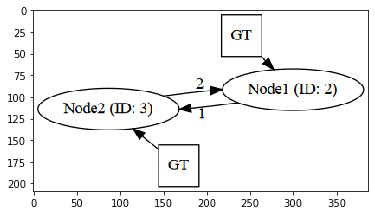

In [4]:
from neural_wrappers.graph import Graph
import matplotlib.pyplot as plt

graph = Graph([edge1, edge2])
print(graph.summary())
graph.draw(fileName="graph")
plt.imshow(plt.imread("graph.png"))
!rm graph.png

##### 4. Creating the Reader for the Graph using some random data

Now that we have the graph defined, we need to create a `Reader` that will give GT data to the nodes. The order of execution is `Node1->Node2` followed by `Node2->Node1`. After the first edge, Node2 will have two possible inputs (`GT` and `Node1->Node2`), by default both are passed. Gradients will also flow back to the first edge for the input generated there, this behaviour is enabled by default but may be desired to be changed.

We see one more function that were not defined in the previous tutorial `getData`, which is part of `DatasetReader` and has the purpose of taking all the dimensions defined in `dataDims` and `lbelDims`, which call the transforms (i.e. normalization, converting to float etc.).

In [5]:
from neural_wrappers.readers import DatasetReader
from neural_wrappers.utilities import getGenerators

class Reader(DatasetReader):
    def __init__(self, nodes):
        allKeys = [node.groundTruthKey for node in nodes]
        super().__init__(self, dataDims=allKeys, labelDims=[])
        
        self.numData = {
            "train" : 1000,
            "validation" : 200
        }
        self.nodes = nodes
        self.dataset = {k : self.computeData(k) for k in self.numData}
        
        for key in allKeys:
            print("Node: %s. Train: %s. Validation: %s" % (key, self.dataset["train"][key].shape, self.dataset["validation"][key].shape))
    
    def computeData(self, k):
        N = self.numData[k]
        keys = [node.groundTruthKey for node in self.nodes]
        numFeatures = [node.numFeatures for node in self.nodes]
        means = [i for i in range(len(self.nodes))] # [0, 1, 2, ...]
        stds = [i * 2 + 1 for i in range(len(self.nodes))] # [1, 3, 5, ...]
        data = {}
        for i in range(len(keys)):
            key, mean, std = keys[i], means[i], stds[i]
            data[key] = std * np.random.randn(N, numFeatures[i]).astype(np.float32) + mean
        return data

    def iterate_once(self, type, miniBatchSize):
        assert type in ("train", "validation")
        dataset = self.dataset[type]
        numIterations = self.getNumIterations(type, miniBatchSize, accountTransforms=False)

        for i in range(numIterations):
            startIndex = i * miniBatchSize
            endIndex = min((i + 1) * miniBatchSize, self.numData[type])
            assert startIndex < endIndex, "startIndex < endIndex. Got values: %d %d" % (startIndex, endIndex)
            data, _ = self.getData(dataset, startIndex, endIndex)
            yield data, data
    
reader = Reader(nodes=[node1, node2])
trainGenerator, trainNumSteps, valGenerator, valNumSteps = getGenerators(reader, miniBatchSize=20)

data = next(trainGenerator)[0]
for k in data:
    print(k, data[k].shape)

Node: node1_gt. Train: (1000, 5). Validation: (200, 5)
Node: node2_gt. Train: (1000, 7). Validation: (200, 7)
node1_gt (20, 5)
node2_gt (20, 7)


##### 5. Training the model

Now, we can wrap it all up by training the model given this random data.

##### 5.1 Default training

[SaveModels] Epoch 1. Improvement (Loss) from 12.62 to 12.62
[SaveModels] Epoch 2. Improvement (Loss) from 12.18 to 12.18
[SaveModels] Epoch 3. Improvement (Loss) from 11.93 to 11.93
[SaveModels] Epoch 4. Improvement (Loss) from 11.77 to 11.77
[SaveModels] Epoch 5. Improvement (Loss) from 11.66 to 11.66
[SaveModels] Epoch 6. Improvement (Loss) from 11.59 to 11.59
[SaveModels] Epoch 7. Improvement (Loss) from 11.54 to 11.54
[SaveModels] Epoch 8. Improvement (Loss) from 11.51 to 11.51
[SaveModels] Epoch 9. Improvement (Loss) from 11.48 to 11.48
[SaveModels] Epoch 10. Improvement (Loss) from 11.46 to 11.46
[SaveModels] Epoch 11. Improvement (Loss) from 11.45 to 11.45
[SaveModels] Epoch 12. Improvement (Loss) from 11.44 to 11.44
[SaveModels] Epoch 13. Improvement (Loss) from 11.43 to 11.43
[SaveModels] Epoch 14. Improvement (Loss) from 11.42 to 11.42
[SaveModels] Epoch 15. Improvement (Loss) from 11.42 to 11.42


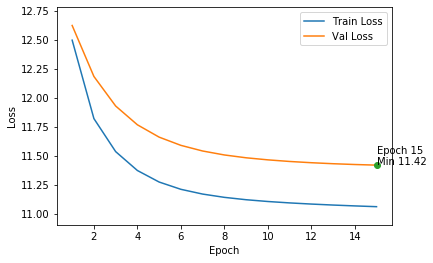

In [6]:
import torch.optim as optim
from neural_wrappers.callbacks import SaveModels, PlotMetrics
tr.manual_seed(42)

trainGenerator, trainNumSteps, valGenerator, valNumSteps = getGenerators(reader, miniBatchSize=20)

edge1 = Edge(node1, node2)
edge2 = Edge(node2, node1)
graph = Graph([edge1, edge2])
graph.setOptimizer(optim.SGD, lr=0.01)
graph.addCallbacks([SaveModels("best"), PlotMetrics(["Loss"])])

graph.train_generator(trainGenerator, trainNumSteps, 15, valGenerator, valNumSteps, printMessage=None)

##### 5.1 Training the model with gradient blocking

We said that we may wish to train the model by blocking the gradients flowing back to the original input. We can do this by setting the field `blockGradients` to `True` for the desired `Edge` (Edge 2 in our case).

[SaveModels] Epoch 1. Improvement (Loss) from 12.63 to 12.63
[SaveModels] Epoch 2. Improvement (Loss) from 12.19 to 12.19
[SaveModels] Epoch 3. Improvement (Loss) from 11.93 to 11.93
[SaveModels] Epoch 4. Improvement (Loss) from 11.77 to 11.77
[SaveModels] Epoch 5. Improvement (Loss) from 11.66 to 11.66
[SaveModels] Epoch 6. Improvement (Loss) from 11.59 to 11.59
[SaveModels] Epoch 7. Improvement (Loss) from 11.54 to 11.54
[SaveModels] Epoch 8. Improvement (Loss) from 11.50 to 11.50
[SaveModels] Epoch 9. Improvement (Loss) from 11.48 to 11.48
[SaveModels] Epoch 10. Improvement (Loss) from 11.46 to 11.46
[SaveModels] Epoch 11. Improvement (Loss) from 11.44 to 11.44
[SaveModels] Epoch 12. Improvement (Loss) from 11.43 to 11.43
[SaveModels] Epoch 13. Improvement (Loss) from 11.42 to 11.42
[SaveModels] Epoch 14. Improvement (Loss) from 11.41 to 11.41
[SaveModels] Epoch 15. Improvement (Loss) from 11.41 to 11.41


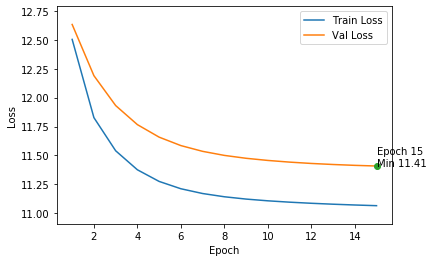

In [7]:
tr.manual_seed(42)

trainGenerator, trainNumSteps, valGenerator, valNumSteps = getGenerators(reader, miniBatchSize=20)
edge1 = Edge(node1, node2)
edge2_block = Edge(node2, node1, blockGradients=True)
graph = Graph([edge1, edge2_block])
graph.setOptimizer(optim.SGD, lr=0.01)
graph.addCallbacks([SaveModels("best"), PlotMetrics(["Loss"])])

graph.train_generator(trainGenerator, trainNumSteps, 15, valGenerator, valNumSteps, printMessage=None)

##### 5.3 Training the model using only predicted output for second link

Perhaps we'd like the back edge `Node2 -> Node1` to use only the generated input from the edge `Node1 -> Node2`. We can do this by updating the edge's forward function to not use the `"GT"` key.

[SaveModels] Epoch 1. Improvement (Loss) from 11.58 to 11.58
[SaveModels] Epoch 2. Improvement (Loss) from 11.19 to 11.19
[SaveModels] Epoch 3. Improvement (Loss) from 10.95 to 10.95
[SaveModels] Epoch 4. Improvement (Loss) from 10.79 to 10.79
[SaveModels] Epoch 5. Improvement (Loss) from 10.68 to 10.68
[SaveModels] Epoch 6. Improvement (Loss) from 10.61 to 10.61
[SaveModels] Epoch 7. Improvement (Loss) from 10.56 to 10.56
[SaveModels] Epoch 8. Improvement (Loss) from 10.52 to 10.52
[SaveModels] Epoch 9. Improvement (Loss) from 10.49 to 10.49
[SaveModels] Epoch 10. Improvement (Loss) from 10.47 to 10.47
[SaveModels] Epoch 11. Improvement (Loss) from 10.45 to 10.45
[SaveModels] Epoch 12. Improvement (Loss) from 10.44 to 10.44
[SaveModels] Epoch 13. Improvement (Loss) from 10.43 to 10.43
[SaveModels] Epoch 14. Improvement (Loss) from 10.41 to 10.41
[SaveModels] Epoch 15. Improvement (Loss) from 10.40 to 10.40


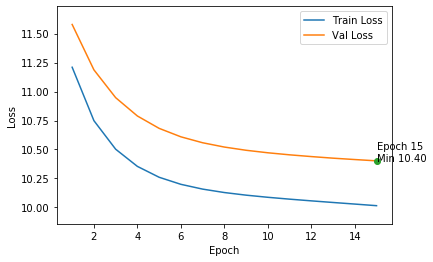

In [8]:
# Use all incoming values as inputs, except GT.
def forwardUseIntermediateResult(self, x):
    A, B, model, edgeID = self.inputNode, self.outputNode, self.model, self.edgeID
    edgeInputs, inputNodeKeys = A.getInputs(blockGradients=self.blockGradients)
    self.inputs = []
    self.outputs = []

    for name, x in zip(inputNodeKeys, edgeInputs):
        if name == "GT":
            continue
        self.inputs.append(x)
        y = model.forward(x)
        self.outputs.append(y)
    return self.outputs

tr.manual_seed(42)
trainGenerator, trainNumSteps, valGenerator, valNumSteps = getGenerators(reader, miniBatchSize=20)

edge1 = Edge(node1, node2)
edge2_no_gt = Edge(node2, node1, forwardFn=forwardUseIntermediateResult)
graph = Graph([edge1, edge2_no_gt])
graph.setOptimizer(optim.SGD, lr=0.01)
graph.addCallbacks([SaveModels("best"), PlotMetrics(["Loss"])])

graph.train_generator(trainGenerator, trainNumSteps, 15, valGenerator, valNumSteps, printMessage=None)